In [1]:
!source .venv/bin/activate
import warnings
warnings.filterwarnings('ignore')


In [22]:
import os
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from copy import deepcopy

#printing
from torch_geometric import utils
import networkx as nx

# Torch
from torch_geometric.nn import GCNConv, TransformerConv
from torch.utils.data import random_split, SubsetRandomSampler, Subset
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from typing import Dict, Tuple


import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
Edges = Dict[Tuple[int, int], Tuple[int, ...]]
Nodes = Dict[int, Tuple[int, ...]]
all_edges: Dict[Tuple[int, int], Tuple[int, ...]] = {}

class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __getitem__(self, index):
        return self.data_list[index]

    def __len__(self):
        return len(self.data_list)

def datasets(data_directory):
    datasets = {}
    for domain_name in os.listdir(data_directory):
        domain_path = os.path.join(data_directory, domain_name)
        data_loader = dataset_from_domain(domain_path)
        datasets[domain_name] = data_loader
    return datasets

def dataset_from_domain(domain_path):
    domain_name = os.path.basename(domain_path)
    dataset = []
    number_of_problems = 0
    for problem_name in os.listdir(domain_path):
        if problem_name == "empty_causal_graphs":
            continue
        number_of_problems+=1
        problem_path = os.path.join(domain_path, problem_name)
        data = problem_path_to_data(problem_path)
        dataset.append(data)
        # Generate list of data objects from our problem path
        
        # Iterate over all the problems in the domain
        # Generate a data object for each problem
        # train_test_split everything
        # train the model
    return dataset




def split_dataset(dataset, test_size=0.2, batch_size=8, shuffle=True, random_seed=42) -> Tuple[DataLoader, DataLoader]:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(0.2 * dataset_size))
    if True :
        np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, test_indicies = indices[split:], indices[:split]

    train_set = []
    test_set = []

    for i in range(len(satellite_dataset)):
        if i in train_indices:
            train_set.append(satellite_dataset[i])
        else:
            test_set.append(satellite_dataset[i])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    return train_loader, test_set

    

def problem_path_to_data(problem_path):
    # print(problem_path)
    cg_df = pd.read_csv(os.path.join(problem_path, 'cg.csv'), index_col=[0, 1])
    cg_df.sort_index(inplace=True)
    nodes_df = pd.read_csv(os.path.join(problem_path, 'nodes.csv'), index_col=0)

    edges = cg_df.index
    edge_features_list = cg_df[['type_pre_eff', 'type_eff_eff']].values
    edge_labels = cg_df['label'].values
    edge_dict = {}

    # Unlucky naming, but the edge_features is a vector representing features of a single edge
    # edge_feature_list is the dictionary of all the edges and their respective features
    for edge, edge_features, label in zip(edges, edge_features_list, edge_labels):
        edge_dict[tuple(edge)] = (edge_features, label)

    edge_features, edge_labels = zip(*[edge_dict[edge] for edge in sorted(edge_dict.keys())])


    data = Data(
        x=torch.tensor(nodes_df.values, dtype=torch.float),
        edge_index=torch.tensor(list(sorted(edge_dict.keys())), dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_features, dtype=torch.float),
        y=torch.tensor(edge_labels, dtype=torch.bool)
    )
    return data

    
def draw_graph(data: Data):
    g = utils.to_networkx(data)

    color = ['green' if data.y[i] else 'red' for i in range(data.y.size(0))]
    a = nx.draw_networkx(g,node_size=200, pos=nx.spectral_layout(g), edge_color=color, node_color='green', with_labels=True)

satellite_dataset = dataset_from_domain('graph_training_data/satellite')
train_loader, test_set = split_dataset(satellite_dataset)



In [25]:
class Net(torch.nn.Module):
    def __init__(self, features_num):
        super(Net, self).__init__()
        self.conv1 = TransformerConv(
            in_channels=features_num,
            out_channels=128,
            edge_dim=2
        )
        self.conv2 = TransformerConv(
            in_channels=128,
            out_channels=64,
            edge_dim=2)

    def encode(self, data: Data):
        x = self.conv1(
            x=data.x,
            edge_index=data.edge_index,
            edge_attr=data.edge_attr) # convolution 1
        x = x.relu()
        return self.conv2(
            x=x, 
            edge_index=data.edge_index,
            edge_attr=data.edge_attr) # convolution 2



    def decode(self, z, edge_index): # only pos and neg edges
        #TODO  edge_index[0] 7 4 9
        #TODO edge_index[1] 5 3 9
        #     print("z shape: ", z.shape)

        # Multiply adjecency matrix with latent space using the COO format of 
        # Edge index[0] and Edge index[1]
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 


        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [26]:
data_loader = train_loader
test_loader = DataLoader(test_set, batch_size=8)

num_node_features = next(iter(data_loader)).x.shape[1]
model = Net(num_node_features)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
batch = next(iter(data_loader))
print(batch[0].x.shape)
print(batch[1].x.shape)

torch.Size([11, 1])
torch.Size([25, 1])


In [27]:
# class DomainTrainer:
#     def __init__(self, train_loader, test_set):
#         self.train_loader = train_loader
#         self.test_set = test_set

#         data_loader = train_loader

#         num_node_features = next(iter(data_loader)).x.shape[1]
#         model = Net(num_node_features)
#         optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
#         batch = next(iter(data_loader))
#         print(batch[0].x.shape)
#         print(batch[1].x.shape)

def train():
    model.train()  # Flag to modify the gradient

    batch = next(iter(data_loader))  # This is next level shit
    # print(batch[0])
    # print(batch[1])
    edge_index = batch.edge_index
    optimizer.zero_grad()
    z = model.encode(batch) 
    link_logits = model.decode(z, edge_index) # decode
    # print(link_logits)
    # print(link_logits)
    link_labels = batch.y
    # print(link_labels)
    link_labels = link_labels.type(torch.float)
    # print(link_labels)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    test_data = next(iter(test_loader))
    z = model.encode(test_data) # encode train
    link_logits = model.decode(z, test_data.edge_index) # decode test or val
    link_probs = link_logits.sigmoid() # apply sigmoid
    link_labels = test_data.y.type(torch.float)
    
    return roc_auc_score(link_labels, link_probs) #compute roc_auc score

In [43]:
best_val_perf = test_perf = 0
epoch_list = []
loss_list = []
test_perf_list = []
for epoch in range(1, 300):
    train_loss = train()

    test_perf = test()
    # if val_perf > best_val_perf:
    #     best_val_perf = val_perf
    #     test_perf = tmp_test_perf
    # log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    log = 'Epoch: {:03d}, Loss: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        epoch_list.append(epoch)
        loss_list.append(train_loss.item())
        test_perf_list.append(test_perf)
        print(log.format(epoch, train_loss, test_perf))

Epoch: 010, Loss: 0.6833, Test: 0.5028
Epoch: 020, Loss: 0.7412, Test: 0.4560
Epoch: 030, Loss: 0.6740, Test: 0.4820
Epoch: 040, Loss: 0.6928, Test: 0.5064
Epoch: 050, Loss: 0.7239, Test: 0.5308
Epoch: 060, Loss: 0.7091, Test: 0.5231
Epoch: 070, Loss: 0.7106, Test: 0.5040
Epoch: 080, Loss: 0.7140, Test: 0.4961
Epoch: 090, Loss: 0.6912, Test: 0.5204
Epoch: 100, Loss: 0.6988, Test: 0.5097
Epoch: 110, Loss: 0.6938, Test: 0.4923
Epoch: 120, Loss: 0.7342, Test: 0.5047
Epoch: 130, Loss: 0.6980, Test: 0.5065
Epoch: 140, Loss: 0.7019, Test: 0.5104
Epoch: 150, Loss: 0.7573, Test: 0.5070
Epoch: 160, Loss: 0.7103, Test: 0.4988
Epoch: 170, Loss: 0.6871, Test: 0.5183
Epoch: 180, Loss: 0.6829, Test: 0.4912
Epoch: 190, Loss: 0.6788, Test: 0.5044
Epoch: 200, Loss: 0.7257, Test: 0.5240
Epoch: 210, Loss: 0.7870, Test: 0.5007
Epoch: 220, Loss: 0.7163, Test: 0.5050
Epoch: 230, Loss: 0.6923, Test: 0.4757
Epoch: 240, Loss: 0.6998, Test: 0.5106
Epoch: 250, Loss: 0.7209, Test: 0.5018
Epoch: 260, Loss: 0.6868,

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]
[0.6833032369613647, 0.7412434816360474, 0.674014151096344, 0.692779541015625, 0.7238699197769165, 0.7091314792633057, 0.7106355428695679, 0.714005172252655, 0.6912204027175903, 0.6988264918327332, 0.693838894367218, 0.7342185974121094, 0.6980340480804443, 0.701926052570343, 0.7572973370552063, 0.7102530002593994, 0.6870602965354919, 0.6828896999359131, 0.6788143515586853, 0.7257009148597717, 0.7870162129402161, 0.7163009643554688, 0.6922961473464966, 0.6997742652893066, 0.720878541469574, 0.6867623925209045, 0.6927794814109802, 0.6937911510467529, 0.7384841442108154]
[0.5027912711591366, 0.4559561575255892, 0.48196671540806457, 0.5064251902153709, 0.5308495873503681, 0.5230550943022131, 0.5039715978091155, 0.496084165654663, 0.5204404074450419, 0.5096842548762051, 0.49228915214751295, 0.5047398944211753, 0.5064778557089396, 0.5104339636670053, 0.5069

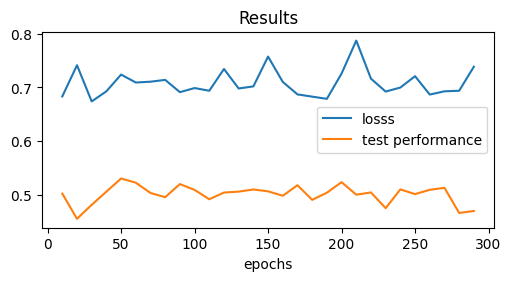

In [46]:
x = np.linspace(0, 2, 100)  # Sample data.
print(epoch_list)
print(loss_list)
print(test_perf_list)

# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(epoch_list, loss_list, label='losss')  # Plot some data on the axes.
ax.plot(epoch_list, test_perf_list, label='test performance')  # Plot more data on the axes...
ax.set_xlabel('epochs')  # Add an x-label to the axes.
ax.set_title("Results")  # Add a title to the axes.
ax.legend();  # Add a legend.